In [2]:
import numpy as np
import pandas as pd # just for reading the data

In [3]:
data = pd.read_csv(r'C:*\fashion-mnist_train.csv')

In [4]:
test_data = pd.read_csv(r'C:*\fashion-mnist_test.csv')

In [5]:
data = np.array(data)
test_data = np.array(test_data)

M, N = data.shape # M=60_000, N=785 as 28*28 + 1 label
test_M, test_N = test_data.shape # (10000, 785)

In [6]:
dev_set_percentage = 0.10

np.random.shuffle(data)

data_dev = data[0:int(M * dev_set_percentage)].T
Y_dev = data_dev[0]
X_dev = data_dev[1:N]

data_train = data[int(M * dev_set_percentage):M].T
Y_train = data_train[0]
X_train = data_train[1:N]

data_test = test_data.T
Y_test = data_test[0]
X_test = data_test[1:test_N]

In [7]:
# Standardize data to have feature values between 0 and 1.
X_train = X_train/255.
X_dev = X_dev/255.
X_test = X_test/255.

print ("X_train's shape: " + str(X_train.shape))
print ("X_dev's shape: " + str(X_dev.shape))
print ("X_test's shape: " + str(X_test.shape))

X_train's shape: (784, 54000)
X_dev's shape: (784, 6000)
X_test's shape: (784, 10000)


In [8]:
def initialize_parameters(layer_dims): # exp. input -> [32, 64, 64, 32, 16]
    np.random.seed(42)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.1
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [9]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    return Z, (A, W, b)

In [10]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z

In [11]:
def relu(Z):
    A = np.maximum(0,Z)
    return A, Z

In [12]:
# cache notation: test test tset deneme git  
# linear_cache has (A, W, b)
# activation_cache has (Z)
# cache = (linear_cache, activation_cache)

In [13]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [14]:
def calculate_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)
          
    return AL, caches

In [15]:
def compute_cost(AL, Y):
    m = Y.shape[0]
    cost = -1 * (1/m) * np.sum(Y * np.log(AL) + (1-Y) * np.log(1-AL))
    
    cost = np.squeeze(cost)
    return cost

In [16]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [17]:
def sigmoid_backward(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [18]:
def relu_backward(dA, cache):
    Z = cache
    
    dZ = np.array(dA, copy=True) # just converting dz to a correct object if there is issue
    dZ[Z <= 0] = 0
    
    return dZ

In [19]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [20]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [21]:
def calculate_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = one_hot(Y)
    # print(caches)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # dAL = AL - Y
    
    current_cache = caches[-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

In [22]:
def update_parameters(params, grads, learning_rate):
    # parameters = copy.deepcopy(params)
    temp_par = params
    parameters = temp_par
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

In [23]:
def validate_model()

SyntaxError: expected ':' (2919965998.py, line 1)

In [24]:
def get_predictions(AL):
    return np.argmax(AL, 0)

def get_accuracy(predictions, Y):
    # print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [48]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 100, print_cost=False):

    # np.random.seed(42)
    costs = [] # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = calculate_model_forward(X, parameters)
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = calculate_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 iterations
        if print_cost and i % 10 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 10 == 0 or i == num_iterations:
            costs.append(cost)
            predictions = get_predictions(AL)
            print(get_accuracy(predictions, Y))
    
    return parameters, costs

In [49]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 784
n_y = 10
layers_dims = (n_x, 28, 28, 28, 14, 14, n_y)
learning_rate = 0.075

In [50]:
parameters, costs = L_layer_model(X_train, Y_train, layers_dims, num_iterations = 15_000, print_cost = True)

(28, 1)
Cost after iteration 0: 6.922170735108954
0.10472222222222222
Cost after iteration 10: 8.144578266753909
0.023240740740740742
Cost after iteration 20: 9.336430485670798
0.040962962962962965
Cost after iteration 30: 10.507767929087482
0.08427777777777777
Cost after iteration 40: 11.660276359849993
0.09724074074074074
Cost after iteration 50: 12.795175586193011
0.09811111111111111
Cost after iteration 60: 13.913540598018162
0.09825925925925925
Cost after iteration 70: 15.01636577415326
0.09842592592592593
Cost after iteration 80: 16.10461975038109
0.09872222222222223
Cost after iteration 90: 17.179274131878422
0.09875925925925925
Cost after iteration 100: 18.241328030448493
0.09887037037037037
Cost after iteration 110: 19.29184036680596
0.099
Cost after iteration 120: 20.331931728731703
0.09920370370370371
Cost after iteration 130: 21.362789835505033
0.09922222222222223
Cost after iteration 140: 22.385683855561187
0.09933333333333333
Cost after iteration 150: 23.401963803669087
0

In [51]:
copy_of_param = parameters

In [85]:
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [54]:
AL_test, caches_test = calculate_model_forward(X_test, parameters)

In [67]:
predictions = get_predictions(AL_test)
print("Results of", len(Y_test), "photos: %" + str(get_accuracy(predictions, Y_test)*100))

Results of 10000 photos: %79.78


In [72]:
predictions

array([0, 1, 2, ..., 8, 8, 6], dtype=int64)

Prediction:  Coat
Label:  Coat


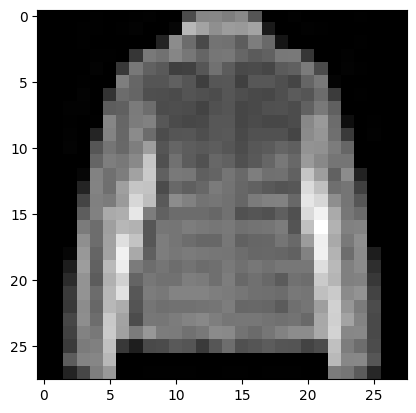

Prediction:  Pullover
Label:  Pullover


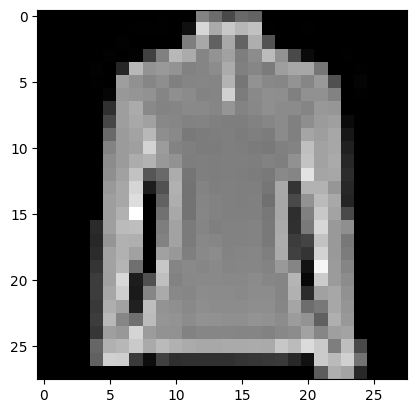

Prediction:  Sandal
Label:  Sandal


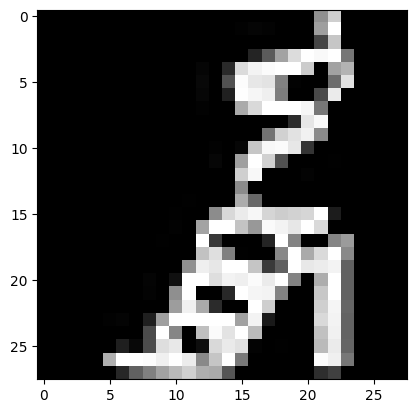

Prediction:  Dress
Label:  Dress


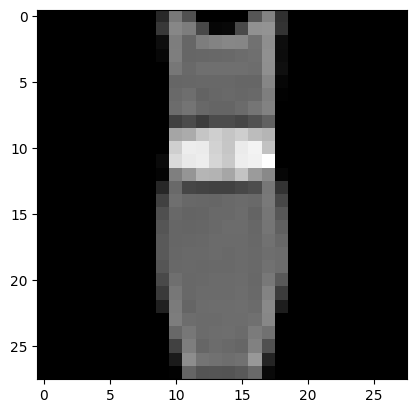

In [88]:
index = [42, 6547, 3213, 9876] # random indexes from test set

for i in index:
    current_image = X_test[:, i, None]
    label = Y_test[i]
    print("Prediction: ", class_labels[predictions[i]])
    print("Label: ", class_labels[label])
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

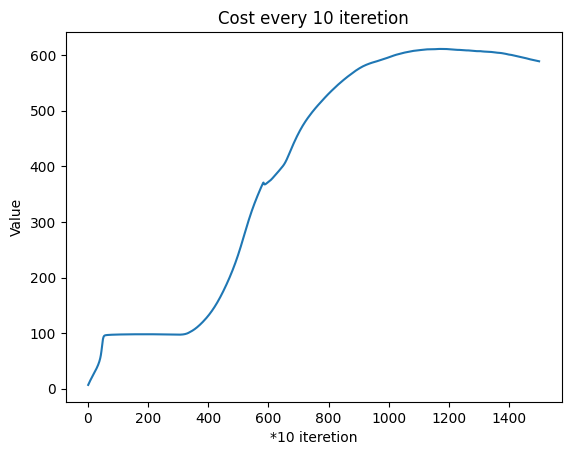

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

data = costs
x_values = range(1, len(data) + 1)

sns.lineplot(x=x_values, y=data)
plt.xlabel('*10 iteretion')
plt.ylabel('Value')
plt.title('Cost every 10 iteretion')
plt.show()